<a href="https://colab.research.google.com/github/PGV1000/data_mining/blob/main/%D0%9C%D0%B5%D0%B4%D0%B2%D0%B5%D0%B4%D0%B5%D0%B2_%D0%9F%D0%A0_%E2%84%965_Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №5. Random forest**

# Задание 1. Обучите классификатор Random Forest для решения задачи бинарной классификации: для каждого человека научиться предсказывать, выживет ли он при крушении Титаника.

Ссылка на датасет: https://www.kaggle.com/c/titanic/data

## 1. Устанавливаем зависимости

In [1]:
%%capture
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix

## 2. Импортируем датасет

In [3]:
# Загружаем датасет из гугл-диска
datadir = 'titanic' # Папка с датасетом
if os.path.isdir(datadir)>0: # Если папка уже есть, то ничего не скачиваем
    print ('Data directory already exists and it is not empty, miss downloading')
else: # Иначе скачиваем и распаковываем
    print ('Data directory does not exists or it is empty, download the dataset')
    !gdown --id 1L9zUaNCNKQCXZiwa20MPoMetapRHTvCI #Скопировать ID из ссылки на файл в гугл диске, предварительно нужно открыть доступ по ссылке.
    !unzip titanic.zip # Распаковка архива

Data directory does not exists or it is empty, download the dataset
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1L9zUaNCNKQCXZiwa20MPoMetapRHTvCI
To: /content/titanic.zip
100% 33.0k/33.0k [00:00<00:00, 40.2MB/s]
Archive:  titanic.zip
   creating: titanic/
  inflating: titanic/gender_submission.csv  
  inflating: titanic/test.csv        
  inflating: titanic/train.csv       


## 3. Производим разведовательный анализ данных


Получим представление о данных в датасете:

In [4]:
df = pd.read_csv('/content/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 4. Сформируем обучающую и тестовую выборки:


In [6]:
x = df.drop(['Survived', 'Name', 'PassengerId', 'Ticket', 'Fare'], axis=1)
y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 1)
x_train.shape, x_test.shape

((596, 7), (295, 7))

## 5. Feature Engineering

Поработаем с признаками, выделим важные, изменим форму их представления (при надобности)

In [7]:
x_train.dtypes

,0
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Cabin,object
Embarked,object


In [8]:
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
496,1,female,54.0,1,0,D20,C
14,3,female,14.0,0,0,NaN,S
82,3,female,NaN,0,0,NaN,Q
657,3,female,32.0,1,1,NaN,Q
388,3,male,NaN,0,0,NaN,Q


In [9]:
encoder = ce.OrdinalEncoder(cols=['Sex', 'Cabin', 'Embarked'])
x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
496,1,1,54.0,1,0,1,1
14,3,1,14.0,0,0,105,2
82,3,1,NaN,0,0,105,3
657,3,1,32.0,1,1,105,3
388,3,2,NaN,0,0,105,3


In [10]:
x_test.head()

,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
862,1,1,48.0,0,0,-1.0,2
223,3,2,NaN,0,0,105.0,2
84,2,1,17.0,0,0,105.0,2
680,3,1,NaN,0,0,105.0,3
535,2,1,7.0,0,2,105.0,2


In [11]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
feature_scores = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores

,0
Age,0.309489
Sex,0.297923
Cabin,0.119017
Pclass,0.103777
SibSp,0.070438
Embarked,0.049906
Parch,0.049450


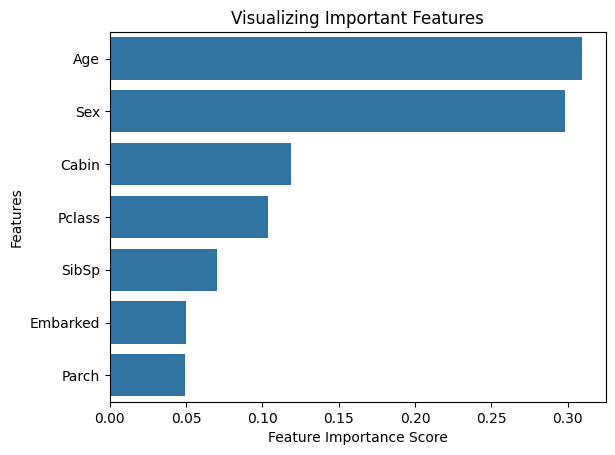

In [12]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## 6. Построение базовой модели:

In [13]:
rf = RandomForestClassifier(n_estimators=8, random_state=1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

## 7. Оценка точности модели:

### 7.1. Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации

In [14]:
def count_metrics(test, prediction):
  cm = confusion_matrix(test, prediction)
  plt.figure(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt =".0f",  cmap='Blues')
  plt.xlabel('Prediction')
  plt.ylabel('GT')
  plt.show()
  print(classification_report(test, prediction))

### 7.2. Оцените точность модели:

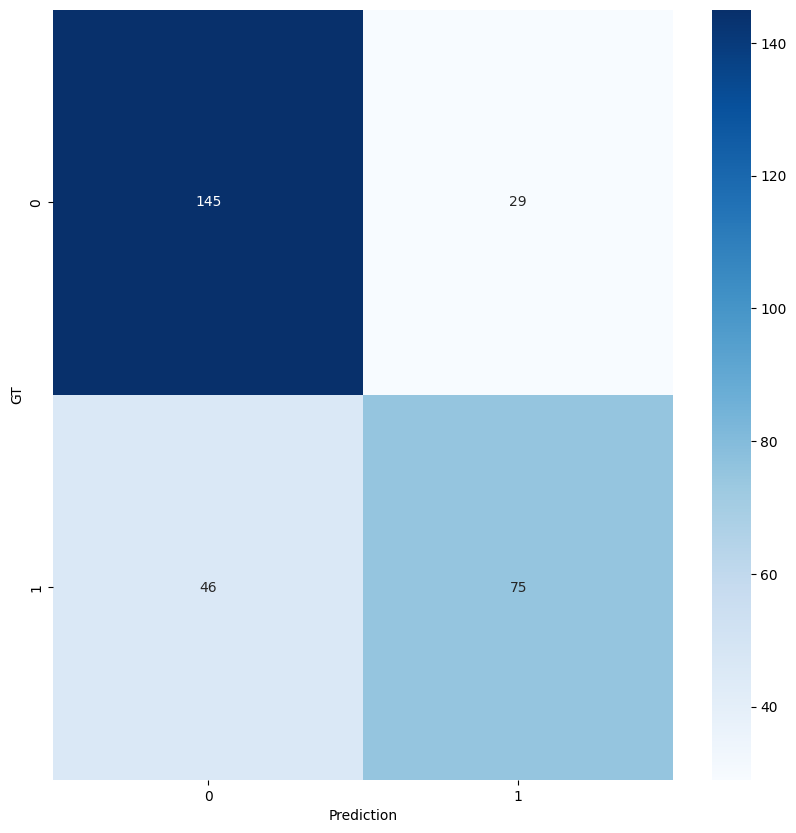

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       174
           1       0.72      0.62      0.67       121

    accuracy                           0.75       295
   macro avg       0.74      0.73      0.73       295
weighted avg       0.74      0.75      0.74       295



In [15]:
y_pred = rf.predict(x_test)
count_metrics(y_test, y_pred)

## 8. Тюнинг гиперпараметров модели:

RandomSearchCV

In [16]:
warnings.filterwarnings('ignore')
n_estimators = [int(x) for x in np.linspace(start=8, stop=100, num=10)]
max_depth = [int(x) for x in np.linspace(1, 100, num=5)]
max_depth.append(None)
max_leaf_nodes = [int(i) for i in range(1, 100)]
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}
rf_clf = RandomForestClassifier(random_state=1)
rf_rand = RandomizedSearchCV(
    estimator=rf_clf,                # модель для настройки
    param_distributions=random_grid, # словарь с параметрами для случайного поиска
    n_iter=50,                      # количество итераций (случайных наборов гиперпараметров)
    scoring='accuracy',              # метрика для оценки качества моделей
    cv=5,                            # количество фолдов для кросс-валидации
    verbose=1,                       # уровень детализации вывода
    random_state=1,                 # фиксированный сид для воспроизводимости результатов
    n_jobs=-1                        # использование всех доступных ядер процессора
)
rf_rand.fit(x_train, y_train)
rf_best_params = rf_rand.best_params_
print(f"Лучшие параметры: {rf_best_params}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'n_estimators': 59, 'max_leaf_nodes': 11, 'max_depth': 25}


GridSearchCV

In [17]:
rf_clf = RandomForestClassifier(random_state=1)
rf_grid = GridSearchCV(
    estimator=rf_clf,                # модель для настройки
    param_grid=random_grid, # словарь с параметрами для случайного поиска
    scoring='accuracy',              # метрика для оценки качества моделей
    cv=2,                            # количество фолдов для кросс-валидации
    verbose=1,                       # уровень детализации вывода
    n_jobs=-1                        # использование всех доступных ядер процессора
)
rf_grid.fit(x_train, y_train)
rf_grid_best_params = rf_grid.best_params_
print(f"Лучшие параметры: {rf_grid_best_params}")

Fitting 2 folds for each of 5940 candidates, totalling 11880 fits
Лучшие параметры: {'max_depth': 25, 'max_leaf_nodes': 12, 'n_estimators': 28}


## 9. Оценка лучшей модели:

Оценка точности базовой модели: 0.7559


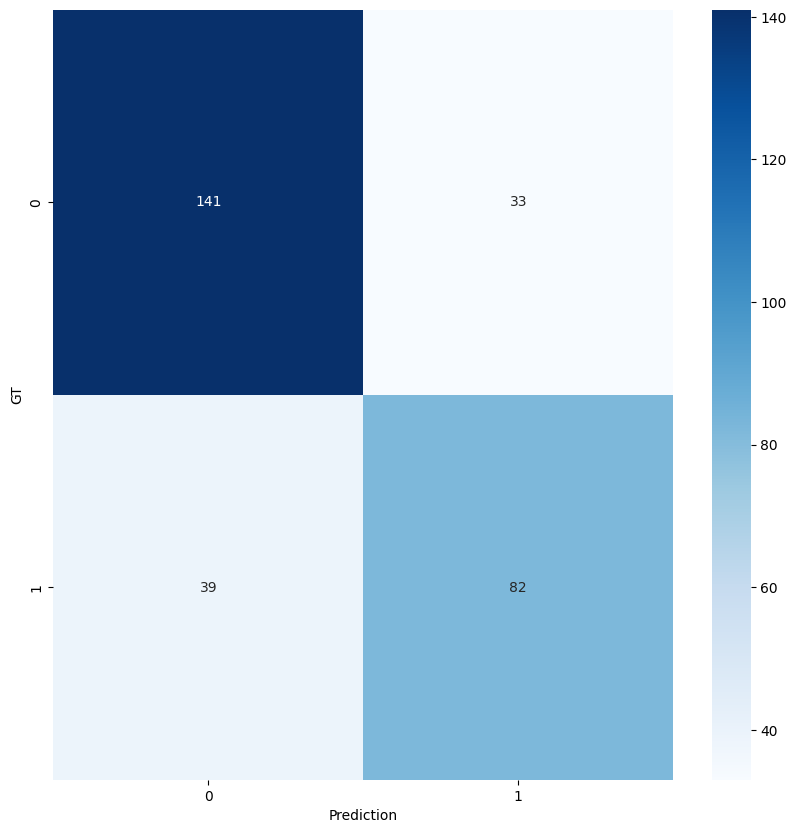

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       174
           1       0.71      0.68      0.69       121

    accuracy                           0.76       295
   macro avg       0.75      0.74      0.75       295
weighted avg       0.75      0.76      0.75       295



In [18]:
rf1 = RandomForestClassifier()
rf1.fit(x_train, y_train)
y_pred1 = rf1.predict(x_test)
print('Оценка точности базовой модели: {0:0.4f}'.format(accuracy_score(y_test, y_pred1)))
count_metrics(y_test, y_pred1)

# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее пройденные классификаторы. Сравните их точность предсказания с Random Forest

Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: 0.7831


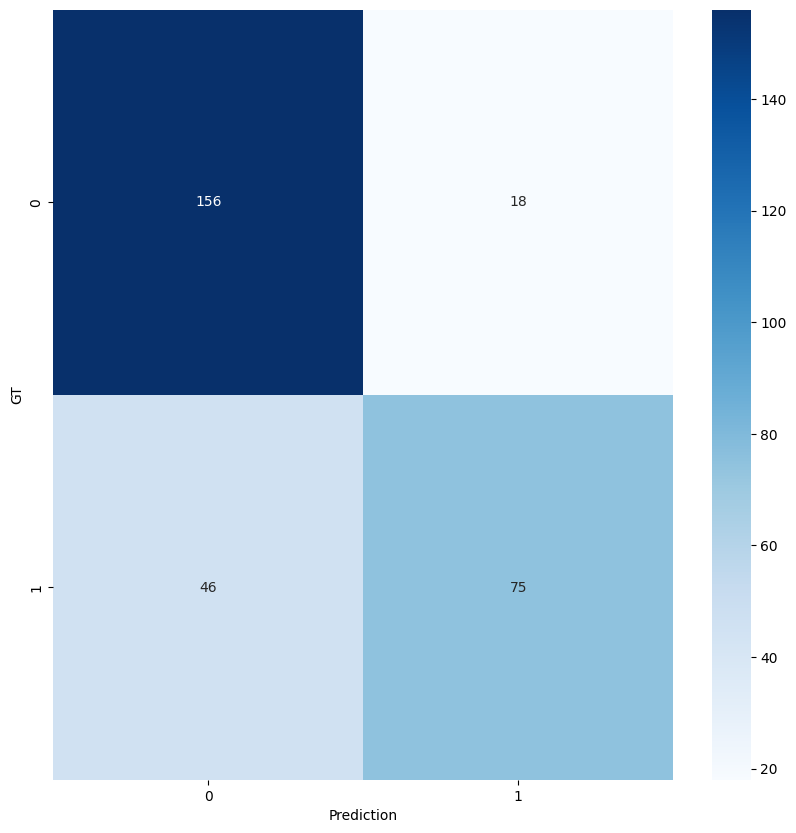

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       174
           1       0.81      0.62      0.70       121

    accuracy                           0.78       295
   macro avg       0.79      0.76      0.77       295
weighted avg       0.79      0.78      0.78       295



In [19]:
rf2 = RandomForestClassifier(**rf_best_params)
rf2.fit(x_train, y_train)
y_pred2 = rf2.predict(x_test)
print('Оценка точности модели при подборе параметров с помощью RandomizedSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred2)))
count_metrics(y_test, y_pred2)

Оценка точности модели при подборе параметров с помощью GridSearchCV: 0.8000


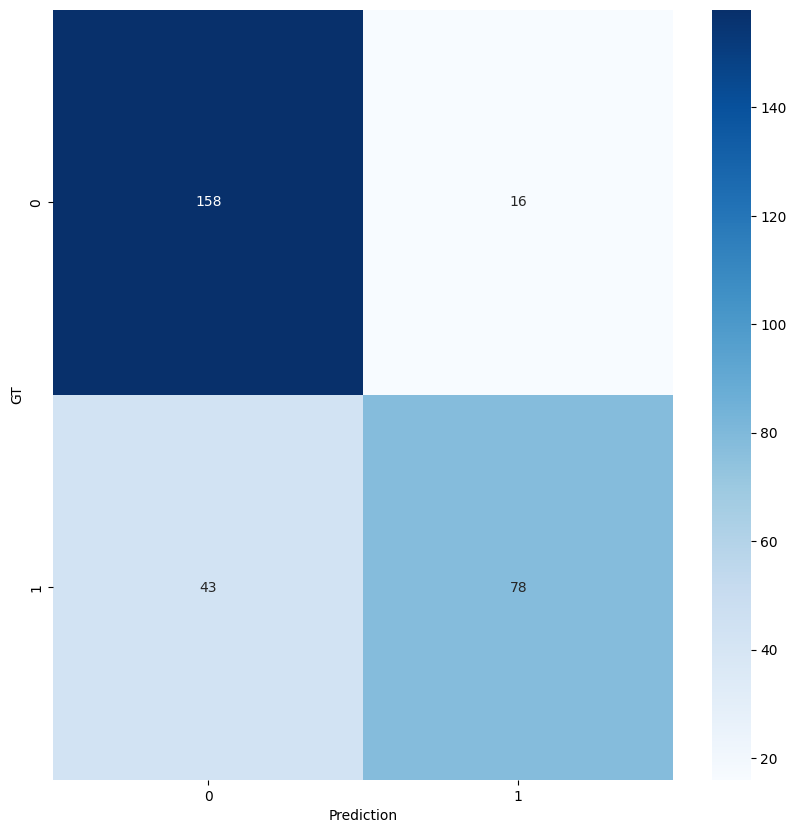

              precision    recall  f1-score   support

           0       0.79      0.91      0.84       174
           1       0.83      0.64      0.73       121

    accuracy                           0.80       295
   macro avg       0.81      0.78      0.78       295
weighted avg       0.80      0.80      0.79       295



In [20]:
rf3 = RandomForestClassifier(**rf_grid_best_params)
rf3.fit(x_train, y_train)
y_pred3 = rf3.predict(x_test)
print('Оценка точности модели при подборе параметров с помощью GridSearchCV: {0:0.4f}'.format(accuracy_score(y_test, y_pred3)))
count_metrics(y_test, y_pred3)

# Задание 2.1*. Реализуйте функцию, для взаимодействия с обученной Вами моделью

* Функция должна принимать на вход обученную модель классификатора;

* После вызова функции, у пользователя через консоль запрашиваются значения признаков. При запросе значений нужно вывести пояснения о типе и диапазоне возможных значений. Также реализуйте обработку исключений;

* После ввода значений для всех признаков в консоль, выводится результат работы классификатора.

In [21]:
print(encoder.get_feature_names)

<bound method BaseEncoder.get_feature_names of OrdinalEncoder(cols=['Sex', 'Cabin', 'Embarked'],
               mapping=[{'col': 'Sex', 'data_type': dtype('O'),
                         'mapping': female    1
male      2
NaN      -2
dtype: int64},
                        {'col': 'Cabin', 'data_type': dtype('O'),
                         'mapping': D20              1
C23 C25 C27      2
C118             3
C103             4
B58 B60          5
              ... 
E34            101
D36            102
C87            103
A10            104
NaN            105
Length: 105, dtype: int64},
                        {'col': 'Embarked', 'data_type': dtype('O'),
                         'mapping': C      1
S      2
Q      3
NaN    4
dtype: int64}])>


In [22]:
y_pred = rf3.predict(x_test)

In [24]:
def predict(model):
  data = pd.DataFrame([{'Pclass': 0,	'Sex': 0, 'Age': 0,	'SibSp': 0,	'Parch': 0,
                        'Cabin': 0,	'Embarked': 0}])
  print('Введите значение \'Pclass\' (билетный класс). Возможные значения:', x_train['Pclass'].unique())
  while not 1 <= (a := int(input())) <= 3 :
    print('Введите одно из возможных значений \'Pclass\':', x_train['Pclass'].unique())
  data['Pclass'] = a
  print('Введите значение \'Sex\' (пол). Возможные значения -', x_train['Sex'].unique(),
        ', где 1 - мужчина, 2 - женщина')
  while not 1 <= (a := int(input())) <= 2 :
    print('Введите одно из возможных значений \'Sex\':', x_train['Sex'].unique())
  data['Sex'] = a
  print('Введите значение \'Age\' (возраст). Диапазон возможных значений: [2, 80]')
  while not 2 <= (a := int(input())) <= 80 :
    print('Введите значение \'Age\' из диапазона [2, 80]:')
  data['Age'] = a
  print('Введите значение \'SibSp\' (количество братьев/сестер/супругов на борту). Диапазон возможных значений: [0, 8]')
  while not 0 <= (a := int(input())) <= 8 :
    print('Введите значение \'SibSp\' из диапазона [0, 8]:')
  data['SibSp'] = a
  print('Введите значение \'Parch\' (количество родителей/детей на борту). Диапазон возможных значений: [0, 6]')
  while not 0 <= (a := int(input())) <= 6 :
    print('Введите значение \'Parch\' из диапазона [0, 6]:')
  data['Parch'] = a
  print('Введите значение \'Cabin\' (номер каюты). Диапазон возможных значений: [1, 112]')
  while not 1 <= (a := int(input())) <= 112 :
    print('Введите значение \'Cabin\' из диапазона [1, 112]:')
  data['Cabin'] = a
  print('Введите значение \'Embarked\' (порт посадки на судно). Возможные значения -',
        x_train['Embarked'].unique(), ', где 1 - Southampton, 2 - Cherbourg, 3 - Queenstown, 4 - не установлено')
  while not 1 <= (a := int(input())) <= 4 :
    print('Введите одно из возможных значений \'Embarked\':', x_train['Embarked'].unique())
  data['Embarked'] = a
  prediction = model.predict(data)
  print('С вероятностью {0:0.4f} пассажир с заданными характеритиками:'.format(accuracy_score(y_test, y_pred)))
  print('не выжил') if prediction == 0 else print('выжил')
predict(rf3)

Введите значение 'Pclass' (билетный класс). Возможные значения: [1 3 2]
3
Введите значение 'Sex' (пол). Возможные значения - [1 2] , где 1 - мужчина, 2 - женщина
1
Введите значение 'Age' (возраст). Диапазон возможных значений: [2, 80]
2
Введите значение 'SibSp' (количество братьев/сестер/супругов на борту). Диапазон возможных значений: [0, 8]
8
Введите значение 'Parch' (количество родителей/детей на борту). Диапазон возможных значений: [0, 6]
6
Введите значение 'Cabin' (номер каюты). Диапазон возможных значений: [1, 112]
50
Введите значение 'Embarked' (порт посадки на судно). Возможные значения - [1 2 3 4] , где 1 - Southampton, 2 - Cherbourg, 3 - Queenstown, 4 - не установлено
3
С вероятностью 0.8000 пассажир с заданными характеритиками:
выжил


# Задание 3. Решите задачу регрессии, используя [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

* Для выполнения данного задания можете использовать **любой датасет**



In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [26]:
# Загружаем датасет
datadir = 'titanic' # Папка с датасетом
if os.path.isdir(datadir)>0:
    print ('Data directory already exists and it is not empty, miss downloading')
else:
    print ('Data directory does not exists or it is empty, download the dataset')
    !gdown --id 1L9zUaNCNKQCXZiwa20MPoMetapRHTvCI
    !unzip titanic.zip

df = pd.read_csv('/content/titanic/train.csv')
df.head()

Data directory already exists and it is not empty, miss downloading


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
# Посмотрим на пропуски в 'Age'
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [28]:
# Удалим строки с пропусками в Age, чтобы иметь чистый набор для регрессии.
df_reg = df.dropna(subset=['Age']).copy()
df_reg.shape

(714, 12)

In [29]:
# В качестве целевой переменной возьмём Age (регрессия)
y = df_reg['Age']
X = df_reg.drop(['Age', 'Name', 'PassengerId', 'Ticket', 'Fare', 'Survived'], axis=1)

In [30]:
# Посмотрим на типы данных
X.dtypes


,0
Pclass,int64
Sex,object
SibSp,int64
Parch,int64
Cabin,object
Embarked,object


In [31]:
# Категориальные признаки: Sex, Cabin, Embarked, Pclass (хотя Pclass - числовой, это категориальный признак категорий классов)
# Проведём кодирование:
encoder = ce.OrdinalEncoder(cols=['Sex','Cabin','Embarked'])
X = encoder.fit_transform(X)
X.head()


,Pclass,Sex,SibSp,Parch,Cabin,Embarked
0,3,1,1,0,135,1
1,1,2,1,0,1,2
2,3,2,0,0,135,1
3,1,2,1,0,2,1
4,3,1,0,0,135,1


In [32]:
# Разделим данные на обучение и тест
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train.shape, x_test.shape

((571, 6), (143, 6))

In [33]:
# Обучим базовую модель
rf = RandomForestRegressor(random_state=1)
rf.fit(x_train, y_train)

RandomForestRegressor(random_state=1)

In [34]:
# Оценим качество предсказания
y_pred = rf.predict(x_test)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
print(f"Базовая модель:\nMSE на тесте: {mse_test:.2f}\nR2 на тесте: {r2_test:.2f}")

Базовая модель:
MSE на тесте: 147.86
R2 на тесте: 0.29


Cabin       0.250957
Pclass      0.239431
SibSp       0.198925
Parch       0.176289
Embarked    0.074228
Sex         0.060170
dtype: float64


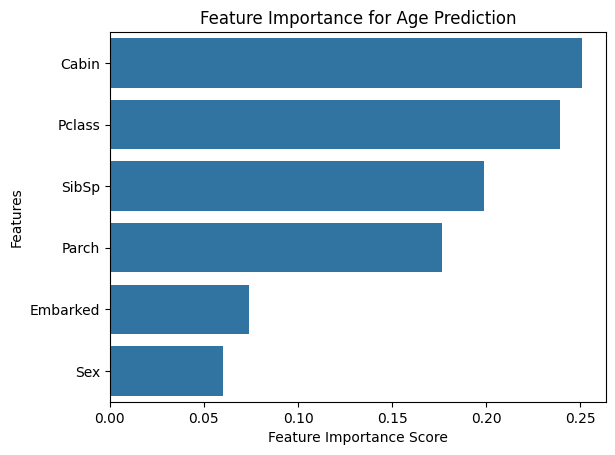

In [35]:
# Посмотрим на важность признаков
feature_scores = pd.Series(rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance for Age Prediction")
plt.show()

In [36]:
# Подбор гиперпараметров RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num=10)]
max_depth = [int(x) for x in np.linspace(2, 50, num=5)]
max_depth.append(None)
max_leaf_nodes = [int(i) for i in range(2, 50)]

In [37]:
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
}

In [38]:

rf_rgr = RandomForestRegressor(random_state=1)

rf_rand = RandomizedSearchCV(
    estimator=rf_rgr,
    param_distributions=random_grid,
    n_iter=50,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=1,
    n_jobs=-1
)

In [39]:
rf_rand.fit(x_train, y_train)
rf_best_params = rf_rand.best_params_
print(f"Лучшие параметры (RandomizedSearchCV): {rf_best_params}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры (RandomizedSearchCV): {'n_estimators': 136, 'max_leaf_nodes': 21, 'max_depth': 26}


In [40]:
# Обучим модель с лучшими параметрами
rf_best = RandomForestRegressor(**rf_best_params, random_state=1)
rf_best.fit(x_train, y_train)
y_pred_best = rf_best.predict(x_test)
mse_test_best = mean_squared_error(y_test, y_pred_best)
r2_test_best = r2_score(y_test, y_pred_best)
print(f"Модель с подобранными параметрами (RandomizedSearchCV):\nMSE на тесте: {mse_test_best:.2f}\nR2 на тесте: {r2_test_best:.2f}")

Модель с подобранными параметрами (RandomizedSearchCV):
MSE на тесте: 142.34
R2 на тесте: 0.32


In [41]:
# Аналогично проведём GridSearchCV, но учитывая, что параметров много, упростим сетку:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'max_leaf_nodes': [5, 10, 20, None]
}


In [42]:
rf_grid = GridSearchCV(
    estimator=rf_rgr,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)


In [43]:
rf_grid.fit(x_train, y_train)
rf_grid_best_params = rf_grid.best_params_
print(f"Лучшие параметры (GridSearchCV): {rf_grid_best_params}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Лучшие параметры (GridSearchCV): {'max_depth': 10, 'max_leaf_nodes': 20, 'n_estimators': 150}


In [44]:
# Обучим модель с лучшими параметрами GridSearchCV
rf_best_grid = RandomForestRegressor(**rf_grid_best_params, random_state=1)
rf_best_grid.fit(x_train, y_train)
y_pred_best_grid = rf_best_grid.predict(x_test)
mse_test_best_grid = mean_squared_error(y_test, y_pred_best_grid)
r2_test_best_grid = r2_score(y_test, y_pred_best_grid)
print(f"Модель с подобранными параметрами (GridSearchCV):\nMSE на тесте: {mse_test_best_grid:.2f}\nR2 на тесте: {r2_test_best_grid:.2f}")

Модель с подобранными параметрами (GridSearchCV):
MSE на тесте: 143.21
R2 на тесте: 0.31
